# Embeddings Analysis

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import distinctipy
import os
from pathlib import Path
from datasets import load_from_disk, Split
from cuml import TSNE
from ettcl.encoding import ColBERTEncoder
from ettcl.modeling import ColBERTModel, ColBERTTokenizer, ColBERTConfig
from ettcl.utils import Checkpoint
from ettcl.indexing import ColBERTIndexer, ColBERTIndexerConfig
from transformers import AutoModelForSequenceClassification

seaborn.set_theme(style="white")

dataset_path = "~/data/trec-6"
checkpoint = "/home/IAIS/hiser/dev/hyped/examples/output/trec_6_bert/model/best-model"

output_dir = "outputs"
text_column = "text"
label_column = "label"

output_dir = os.path.join("outputs", os.path.basename(dataset_path))
plot_dir = os.path.join(output_dir, "plots")
Path(plot_dir).mkdir(exist_ok=True, parents=True)

In [2]:
dataset = load_from_disk(os.path.expanduser(dataset_path))
dataset.set_format("torch")

train_dataset = dataset[Split.TRAIN]
# train_dataset = train_dataset.train_test_split(train_size=500, stratify_by_column='label')['train']
test_dataset = dataset[Split.TEST]

label_names = train_dataset.features[label_column].names

train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 4906
})

## Load finetuned hyped model

In [3]:
config = ColBERTConfig.from_pretrained(checkpoint, normalize=True)
model = ColBERTModel.from_pretrained(checkpoint, config=config)
tokenizer = ColBERTTokenizer.from_pretrained(checkpoint, add_special_tokens=True, doc_token=None, query_token=None)
encoder = ColBERTEncoder(model, tokenizer)

Some weights of the model checkpoint at /home/IAIS/hiser/dev/hyped/examples/output/trec_6_bert/model/best-model were not used when initializing ColBERTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ColBERTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ColBERTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
encoder.cuda()
all_token_embeddings, all_doc_lengths = encoder.encode_passages(train_dataset[text_column], to_cpu=True)
encoder.cpu();

all_token_embeddings = all_token_embeddings.float()
labels = train_dataset[label_column]
unique_labels = labels.unique()
num_labels = len(unique_labels)

all_token_embeddings.shape

Encoding:   0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([66056, 768])

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

def extract_cls_embeddings(embeddings: list[torch.Tensor], seq_lengths: list[int]):
    offsets = torch.tensor([0, *seq_lengths]).cumsum(0)
    return embeddings[offsets[:-1]]

def extract_mean_embeddings(embeddings: list[torch.Tensor], seq_lengths: list[int]):
    offsets = torch.tensor([0, *seq_lengths]).cumsum(0)
    return torch.stack([embeddings[offset:endpos].mean(0) for offset, endpos in zip(offsets[:-1], offsets[1:])])

def extract_prefix_embeddings(embeddings: list[torch.Tensor], seq_lengths: list[int]):
    offsets = torch.tensor([0, *seq_lengths]).cumsum(0)
    return embeddings[offsets[:-1] + 1]

def extract_pure_token_embeddings(embeddings: list[torch.Tensor], seq_lengths: list[int], has_doc_token: bool = False):
    offsets = torch.tensor([0, *seq_lengths]).cumsum(0)
    seq_start = 2 if has_doc_token else 1  # removes [CLS] and optional [D],[Q] token
    seq_end = 1  # removes [SEP] token
    new_embeddings = torch.cat([embeddings[offset + seq_start: endpos - seq_end] for offset, endpos in zip(offsets[:-1], offsets[1:])])
    new_lengths = [l - seq_start - seq_end for l in seq_lengths]
    return new_embeddings, new_lengths

def assign_labels(seq_lengths: list[int], labels: list[int]):
    return torch.cat([torch.full((length,), label) for label, length in zip(labels, seq_lengths)])

def assign_doc_ids(seq_lengths: list[int], labels: list[int]):
    return torch.cat([torch.full((length,), doc_id) for doc_id, length in enumerate(seq_lengths)])

def subsample(embeddings: list[torch.Tensor], seq_lengths: list[int], labels: list[int], n: int, stratify: bool = True):
    offsets = torch.tensor([0, *seq_lengths]).cumsum(0)
    boundaries = torch.stack([offsets[:-1], offsets[1:]], dim=1)

    if stratify:
        splitter = StratifiedShuffleSplit(n_splits=1, train_size=n)
        random_indices = next(splitter.split(torch.arange(len(boundaries)), labels))[0]
    else:
        random_indices = torch.randperm(len(boundaries))[:n]

    boundaries = boundaries[random_indices]
    lengths = boundaries[:, 1] - boundaries[:, 0]
    labels = assign_labels(lengths, labels[random_indices])
    embeddings = torch.cat([embeddings[bound[0]: bound[1]] for bound in boundaries])

    return embeddings, lengths, labels

In [6]:
config = ColBERTIndexerConfig(num_partitions=len(np.unique(labels)), kmeans_niters=10)
indexer = ColBERTIndexer(encoder, config)

index_path = os.path.join(output_dir, "index")
# indexer.index(index_path, train_dataset.with_format('torch')['text'])

In [7]:
# loading centroids from index
# centroids = torch.load(os.path.join(index_path, "centroids.pt"), map_location='cpu')

# centroids from model prediction head
model_with_head = AutoModelForSequenceClassification.from_pretrained(checkpoint)
weight = model_with_head.classifier.weight.detach()
bias = model_with_head.classifier.bias.detach()
centroids = weight

centroids.shape

torch.Size([6, 768])

In [8]:
cls_token_embeddings = extract_cls_embeddings(all_token_embeddings, all_doc_lengths)
mean_token_embeddings = extract_mean_embeddings(all_token_embeddings, all_doc_lengths)
pure_token_embeddings, pure_token_lengths = extract_pure_token_embeddings(all_token_embeddings, all_doc_lengths)
pure_token_labels = assign_labels(pure_token_lengths, labels)

# pure_token_embeddings, pure_token_lengths, pure_token_labels = subsample(pure_token_embeddings, pure_token_lengths, labels, n=200)
# pure_token_embeddings.shape

In [9]:
cls_token_embeddings = torch.nn.functional.tanh(
    model_with_head.bert.pooler.dense(cls_token_embeddings)
).detach()

mean_token_embeddings = torch.nn.functional.tanh(
    model_with_head.bert.pooler.dense(mean_token_embeddings)
).detach()

pure_token_embeddings = torch.nn.functional.tanh(
    model_with_head.bert.pooler.dense(pure_token_embeddings)
).detach()

In [10]:
def tsne(*embeddings, **kwargs):
    inputs = torch.cat(embeddings)
    offsets = torch.tensor([0] + [t.shape[0] for t in embeddings]).cumsum(dim=0)

    vecs = TSNE(**kwargs).fit_transform(torch.cat(embeddings).numpy())
    vecs = torch.from_numpy(vecs)

    return (vecs[offset:endpos] for offset, endpos in zip(offsets[:-1], offsets[1:]))

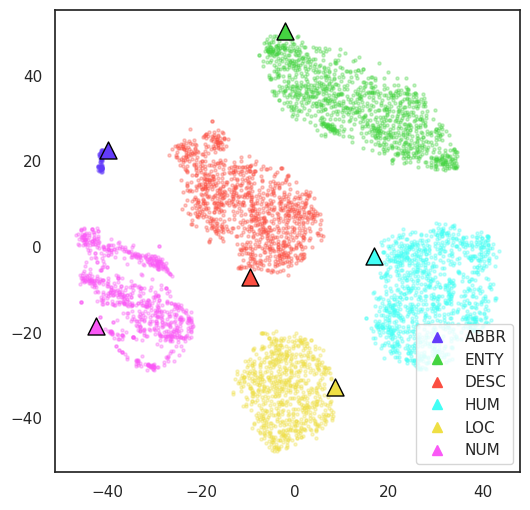

In [39]:
emb_vecs, centroid_vecs = tsne(cls_token_embeddings, centroids, metric='cosine', perplexity=50)

colors = distinctipy.get_colors(num_labels, pastel_factor=0.3)#, exclude_colors=exclude_colors)
plt.figure(figsize=(6, 6))

for i, label in enumerate(unique_labels):
    vecs_ = emb_vecs[labels == label]
    sample_size = min(len(vecs_), 2_000)
    indices = np.random.choice(vecs_.shape[0], size=sample_size, replace=False)
    vecs_ = vecs_[indices]
    plt.scatter(*vecs_.T, color=colors[i], s=5, alpha=0.3);

for i, label in enumerate(unique_labels):
    plt.scatter(*centroid_vecs[i].T, s=150, color=colors[i], marker='^', alpha=1, edgecolors='black')

legend_handles = [plt.Line2D([], [], color=colors[i], marker='^', linestyle='', markersize=7, alpha=1) for i in range(num_labels)]
legend_labels = label_names

plt.legend(legend_handles, legend_labels, loc='lower right');
plt.savefig(os.path.join(plot_dir, "cls_token_weight_centroids.pdf"), )

/home/IAIS/hiser/miniconda3/envs/colbert/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [23:59:18.505829] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


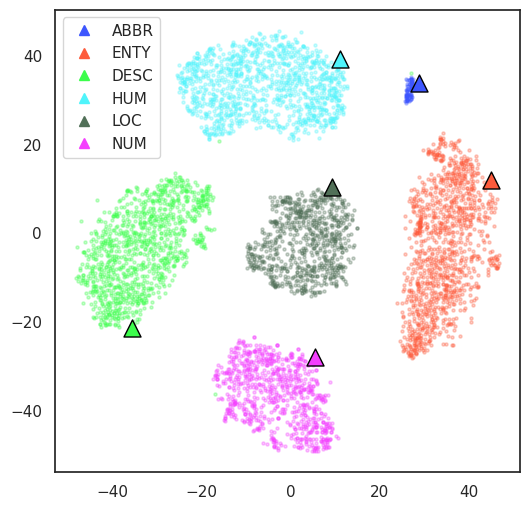

In [41]:
emb_vecs, centroid_vecs = tsne(mean_token_embeddings, centroids, metric='cosine', perplexity=50)

colors = distinctipy.get_colors(num_labels, pastel_factor=0.3)#, exclude_colors=exclude_colors)
plt.figure(figsize=(6, 6))

for i, label in enumerate(unique_labels):
    vecs_ = emb_vecs[labels == label]
    sample_size = min(len(vecs_), 2_000)
    indices = np.random.choice(vecs_.shape[0], size=sample_size, replace=False)
    vecs_ = vecs_[indices]
    plt.scatter(*vecs_.T, color=colors[i], s=5, alpha=0.3);

for i, label in enumerate(unique_labels):
    plt.scatter(*centroid_vecs[i].T, s=150, color=colors[i], marker='^', alpha=1, edgecolors='black')

legend_handles = [plt.Line2D([], [], color=colors[i], marker='^', linestyle='', markersize=7, alpha=1) for i in range(num_labels)]
legend_labels = label_names

plt.legend(legend_handles, legend_labels);
plt.savefig(os.path.join(plot_dir, "mean_token_weight_centroids.pdf"), )

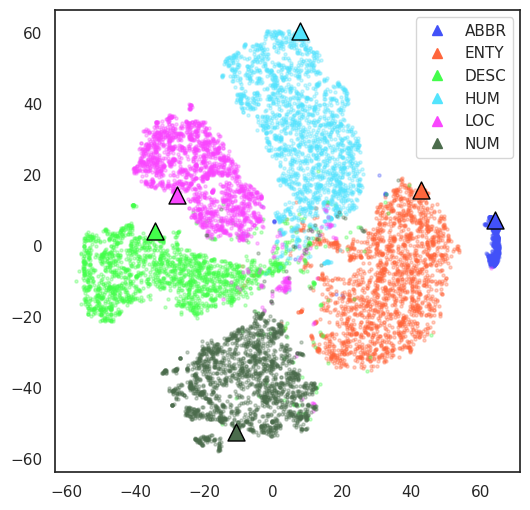

In [43]:
# emb_vecs, centroid_vecs = tsne(pure_token_embeddings, centroids, metric='cosine', perplexity=50)

colors = distinctipy.get_colors(num_labels, pastel_factor=0.3)#, exclude_colors=exclude_colors)
plt.figure(figsize=(6, 6))

for i, label in enumerate(unique_labels):
    vecs_ = emb_vecs[pure_token_labels == label]
    sample_size = min(len(vecs_), 2_000)
    indices = np.random.choice(vecs_.shape[0], size=sample_size, replace=False)
    vecs_ = vecs_[indices]
    plt.scatter(*vecs_.T, color=colors[i], s=5, alpha=0.3);

for i, label in enumerate(unique_labels):
    plt.scatter(*centroid_vecs[i].T, s=150, color=colors[i], marker='^', alpha=1, edgecolors='black')

legend_handles = [plt.Line2D([], [], color=colors[i], marker='^', linestyle='', markersize=7, alpha=1) for i in range(num_labels)]
legend_labels = label_names

plt.legend(legend_handles, legend_labels);
plt.savefig(os.path.join(plot_dir, "pure_token_weight_centroids.pdf"), )

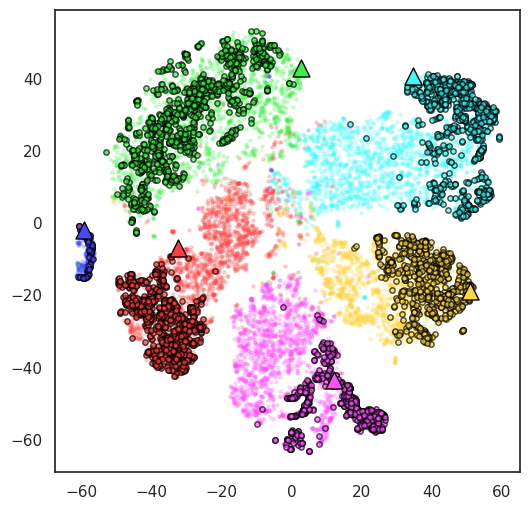

In [48]:
# pure_vecs, cls_vecs, centroid_vecs = tsne(pure_token_embeddings, cls_token_embeddings, centroids, metric='cosine', perplexity=50)

colors = distinctipy.get_colors(num_labels, pastel_factor=0.3)#, exclude_colors=exclude_colors)
plt.figure(figsize=(6, 6))

for i, label in enumerate(unique_labels):
    vecs_ = pure_vecs[pure_token_labels == label]
    sample_size = min(len(vecs_), 2_000)
    indices = np.random.choice(vecs_.shape[0], size=sample_size, replace=False)
    vecs_ = vecs_[indices]
    plt.scatter(*vecs_.T, color=colors[i], s=5, alpha=0.2);

    vecs_ = cls_vecs[labels == label]
    sample_size = min(len(vecs_), 2_000)
    indices = np.random.choice(vecs_.shape[0], size=sample_size, replace=False)
    vecs_ = vecs_[indices]
    plt.scatter(*vecs_.T, color=colors[i], s=15, alpha=0.7, marker='o', edgecolors='black');

for i, label in enumerate(unique_labels):
    plt.scatter(*centroid_vecs[i].T, s=150, color=colors[i], marker='^', alpha=1, edgecolors='black')

legend_handles = [plt.Line2D([], [], color=colors[i], marker='^', linestyle='', markersize=7, alpha=1) for i in range(num_labels)]
legend_labels = label_names

# plt.legend(legend_handles, legend_labels, ncol=2, bbox_to_anchor=(1.01, 1), loc='upper left')
plt.savefig(os.path.join(plot_dir, "all_token_weight_centroids.pdf"))